# Qeexo Machine Learning Challenge
The goal of the challenge is to write a program that takes input files describing information about a touch on a
mobile device and determines whether the touch is from a finger pad or knuckle. Your program will classify
approximately 10,000 unlabeled touches.

In [1]:
from utility import load_instances, load_labels, load_timestamps, convert_to_classlabels, write_results
from SVM import SVM
import sys
import os
import csv
import numpy as np
import scipy.io.wavfile
from sklearn.utils import shuffle
import cvxopt
import  scipy as sp
from sklearn import svm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#  First Step:

1. Feature Selection and  Adding Features
2. Used Audio.wav and Touch.csv features
3. From touch.csv - Selected x,y,major and minor features
4. From Touch.csv - Removed orientation and Pressure has zero variance and not helping much more
5. Used Z-score normailization Technique to normalize the inputs

In [20]:
def normailze(X):
    '''
    Z-score normailzation to normailze the data.
    '''
    standard_deviation = np.std(X)
    mean = X.mean(axis = 0)
    X = (X - mean)/standard_deviation
    return X

def generate_features(instances):
    """ generate features
        param instances: a list of Instance class objects
        return: a feature matrix
    """
    # create a naive feature set
    X = np.array([instance.audio.astype(float) for instance in instances])
    X = np.hstack((X, np.array([instance.touch['y'] for instance in instances]).reshape(X.shape[0], 1)))
    X = np.hstack((X, np.array([instance.touch['x'] for instance in instances]).reshape(X.shape[0], 1)))
    X = normailze(X)
    X = np.hstack((X, np.array([instance.touch['major'] for instance in instances]).reshape(X.shape[0], 1)))
    X = np.hstack((X, np.array([instance.touch['minor'] for instance in instances]).reshape(X.shape[0], 1)))
    #X = np.hstack((X, (3.14 * (np.array([instance.touch['minor'] for instance in instances]) / 2.0) *
                   #( np.array([instance.touch['major'] for instance in instances]) / 2.0)).reshape(20659, 1)))
    return X

def train_model(X, y):
    """ train a model (1 nearest neighbor)
        param X: a feature matrix
        param y: a vector contains labels
        return : trained model
    """
    # train a naive model (1-NN)
    model = {"X": X, "y": y}
    return model

                  
def test_model(X_test, model):
    """ test a model (1 nearest neighbor)
        param X_test: a feature matrix
        param model: trained 1 NN model (copy of training data)
        return : predicted labels for test data
    """
    # test a 1-NN model
    X_train = model["X"]
    y_train = model["y"]
    y_test = np.zeros(X_test.shape[1], dtype=int)
    for i in range(X_test.shape[1]):
        #temp = X_train.T-X_test[:,i]
        y_test[i] = y_train[:,np.argmin(np.sum((X_train.T-X_test[:,i])**2, axis=1)**0.5)]
    return y_test


def accuracy(X_Labels, Y_Labels):
    '''
    created a function to calculate accuracy  of prediction
    and return the percentage
    '''
    total =0
    size = Y_Labels.shape[0]
    i =0
    print X_Labels.reshape, Y_Labels.shape
    while(i < size):
        if (X_Labels[:,i] == Y_Labels[i]):
            total = total+1
            i = i+1
        else:
            i = i+1

    return ((float(total) / size) * 100)

def cross_validation_k(all_data_set, all_data_labels, K):
    '''
    cross validation function will create K-fold training and testing set.
    I have took a little different approach here and divided the total with k to get the testing portion
    and rest will be the training_set
    it will return an array of K-fold size containing training and testing dataset 
    '''

    total_number = all_data_set.shape[0];
    partion_ratio = int (total_number / K) ;
    start =0;
    end = partion_ratio;
    #self.accuracy = [];
    # k -fold validation :

    all_data_set, all_data_labels  = shuffle(all_data_set, all_data_labels, random_state = 1234)

    training_dataset = []
    training_labels = []
    testing_dataset = []
    testing_labels = []
    for i in range(0,K):
        new_testing_set= np.copy(all_data_set.T[:,start:end])
        new_testing_labels = np.copy(all_data_labels.T[:,start:end])
        range_i = [ x for x in range(start,end)];
        new_training_set =  np.delete(all_data_set.T,range_i, axis=1 )
        new_training_labels = np.delete(all_data_labels.T,range_i, axis=1 )
        start = end
        end = partion_ratio+end
        training_dataset.append(new_training_set)
        training_labels.append(new_training_labels)
        testing_dataset.append(new_testing_set)
        testing_labels.append(new_testing_labels)
    return training_dataset,training_labels, testing_dataset, testing_labels
    
def confusion_mat(target_labels, testing_labels):
    '''
    create confusion matrix to see the performance of a classification model
    true positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
    true negatives (TN): We predicted no, and they don't have the disease.
    false positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
    false negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")
    '''
    
    matrix = np.zeros((2,2))
    for i in range(0, target_labels.shape[1]):
        if (testing_labels[i] ==0):
            if (target_labels[:,i] == testing_labels[i]):
                matrix[0][0] += 1
            else:
                matrix[0][1] +=1
        else:
            if (target_labels[:,i] == testing_labels[i]):
                matrix[1][1] += 1
            else:
                matrix[1][0] +=1
   
    return matrix

def svm_model(ker, softmargin, training_set,training_labels, testing_set):
    '''
    created svm model libraray provided by sklearn .
    I have implemented SVM library but for various kernel I need to used this sk-learn libraray 
    
    '''
    classifier = svm.SVC(kernel=ker, C=softmargin, gamma= 0.01, class_weight={1:1.2})
    #print np.count_nonzero(new_training_labels)
    classifier.fit(training_set.T, training_labels.reshape(training_labels.shape[1],1).ravel())
    y_test = classifier.predict(testing_set.T)
    return y_test

def logisticRegression_model(training_set,training_labels, testing_set):
    '''
    created LogisticRegression model libraray provided by sklearn. 
    '''
    classifier = linear_model.LogisticRegression()
    classifier.fit(training_set.T, training_labels.reshape(training_labels.shape[1],1).ravel())
    y_test = classifier.predict(testing_set.T)
    return y_test

def plot_confusion_matrix(conf):
    '''
    ploting confusion matrix for visulization.
    
    '''
    classes = [0,1]
    plt.imshow(conf, cmap='binary', interpolation='None')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()
    return conf

def accuracy_plot(accuracy_r, k, Title):
    '''
    To plot accurcay for various models to analyze the models performance.
    '''
    plt.plot(accuracy_r)
    plt.title(Title)
    plt.xlabel('K-Fold')
    plt.ylabel('Accuracy')
    plt.axis([0, k, 0, 100])
    plt.show()

In [21]:
'''
Loading the dataset and reshaping 
'''
train_instances = load_instances("data/train")
X_train = generate_features(train_instances)
print "Feature Vector" , X_train.shape
y_trains = load_labels(train_instances)
y_train = y_trains.reshape(y_trains.shape[0],1)

Feature Vector (20659L, 260L)


# K-Fold Cross Validation 

In [17]:
'''
cross_validation function and create 
training_dataset,training_labels, testing_dataset, testing_labels
'''
K_fold = 10 # Enter the  number of fold you require
training_dataset,training_labels, testing_dataset, testing_labels = cross_validation_k(X_train, y_train,K_fold)

# Created small _dataset for experiement purpose
#training_dataset,training_labels, testing_dataset, testing_labels = cross_validation_k(X_train[:2000,], y_train[:2000,],K_fold)


# Experiment :  KNN Classifier

1. Used the KNN provided in Example.
2. To Find the K value I have used GridSearch
3. From my experiement concluded Best K = 1

<built-in method reshape of numpy.ndarray object at 0x000000003A0400D0> (2065L,)
Accuracy : 92.3002421308
[[ 992.  120.]
 [  39.  914.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A040620> (2065L,)
Accuracy : 92.6876513317
[[ 1018.   116.]
 [   35.   896.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A040350> (2065L,)
Accuracy : 92.8329297821
[[ 1006.   106.]
 [   42.   911.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A040CB0> (2065L,)
Accuracy : 92.6876513317
[[ 1000.   114.]
 [   37.   914.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A51E760> (2065L,)
Accuracy : 92.1549636804
[[ 996.  120.]
 [  42.  907.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A51E3A0> (2065L,)
Accuracy : 93.3171912833
[[ 972.  110.]
 [  28.  955.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A51E800> (2065L,)
Accuracy : 91.8644067797
[[ 1015.   129.]
 [   39.   882.]]
<built-in method reshape 

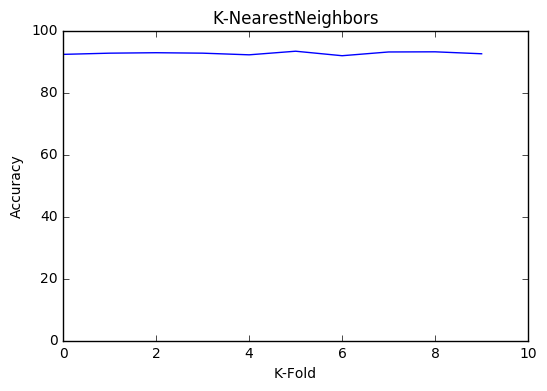

In [22]:
Y_test = [] # to store all fold results
accuracy_r = [] # to store accuracy for plotting
total =0
for i in range(0,K_fold):
    # calling KNN model 
    model = train_model(training_dataset[i], training_labels[i])
    y_test = test_model(testing_dataset[i], model)
    result = accuracy(testing_labels[i], y_test)
    print "Accuracy :", result
    accuracy_r.append(result)
    Y_test.append(y_test)
    total = total+result
    # creating 
    cf = confusion_mat(testing_labels[i], Y_test[i])
    print cf
print "Average Accuracy :" , total / K_fold
# plot accuracy 
accuracy_plot(accuracy_r,K_fold,"K-NearestNeighbors")

# Experiment: Logistic Regression

1. Used Simple Logistic Regression
2. Used Sk-Learn LogisticRegreesion Module
3. As we have to predict binary classification thought one first to try using Logistic would be great idea
4. Data set is large , I know computational it will be fast compare to SVM Liner Kernel

<built-in method reshape of numpy.ndarray object at 0x000000004789F210> (2065L,)
Accuracy : 81.8401937046
[[ 842.  186.]
 [ 189.  848.]]
<built-in method reshape of numpy.ndarray object at 0x000000004789FC60> (2065L,)
Accuracy : 80.8232445521
[[ 861.  204.]
 [ 192.  808.]]
<built-in method reshape of numpy.ndarray object at 0x000000004789F670> (2065L,)
Accuracy : 80.8232445521
[[ 850.  198.]
 [ 198.  819.]]
<built-in method reshape of numpy.ndarray object at 0x000000004789FC10> (2065L,)
Accuracy : 82.5181598063
[[ 885.  209.]
 [ 152.  819.]]
<built-in method reshape of numpy.ndarray object at 0x000000004789FDF0> (2065L,)
Accuracy : 81.3559322034
[[ 872.  219.]
 [ 166.  808.]]
<built-in method reshape of numpy.ndarray object at 0x000000004789F940> (2065L,)
Accuracy : 81.6464891041
[[ 861.  240.]
 [ 139.  825.]]
<built-in method reshape of numpy.ndarray object at 0x000000004789FEE0> (2065L,)
Accuracy : 81.1622276029
[[ 881.  216.]
 [ 173.  795.]]
<built-in method reshape of numpy.ndarray

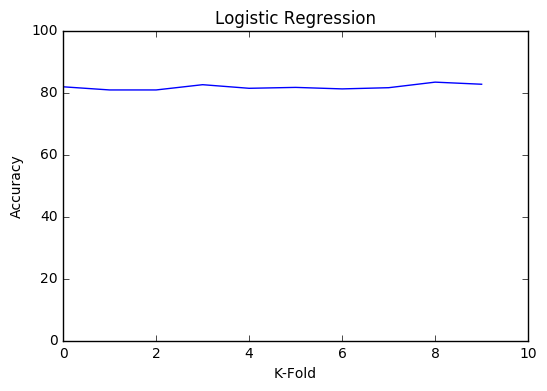

In [369]:
Y_test = []
accuracy_r = []
total =0
for i in range(0,K_fold):
    y_test = logisticRegression_model(training_dataset[i],training_labels[i],testing_dataset[i])
    result = accuracy(testing_labels[i], y_test)
    print "Accuracy :", result
    accuracy_r.append(result)
    Y_test.append(y_test)
    total = total + result
    cf = confusion_mat(testing_labels[i], Y_test[i])
    print cf
print "Average Accuracy :" , total / K_fold
accuracy_plot(accuracy_r,K_fold,"Logistic Regression")

# Experiment: Support Vector Machine

Selected SVM as per the Research Paper Finding and Obvious it is one of the best classifier

# SVM - Linear Kernal
1. Started with my SVM  Linear library 
2. For this experiment I have used my own SVM library 
2. Achieved the 85-88% of average accuracy on 10 k-Fold 

# SVM - Polynomial Kernal

1. Used Sklearn SVC classfier with ploy kernel
2. Achieved 89-90% accuracy on 10 k-Fold 

# SVM - RBF Kernal
1. Used Sklearn SVC classfier - rbf Kernel
2. Achieved 91-94% accuracy on 10 k-Fold 

# GridSearchCV sklearn to find the optimize parameter for SVM

1. Used Grid Search CV Sklearn module
2. Cross Validation = 3
3. To find which kernel will permorn best with other soft margin and other tuning parameters
4. {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}

<built-in method reshape of numpy.ndarray object at 0x000000003A0400D0> (2065L,)
Accuracy : 93.7046004843
[[ 978.   77.]
 [  53.  957.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A040620> (2065L,)
Accuracy : 94.382566586
[[ 1013.    76.]
 [   40.   936.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A040350> (2065L,)
Accuracy : 93.6561743341
[[ 997.   80.]
 [  51.  937.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A040CB0> (2065L,)
Accuracy : 94.382566586
[[ 997.   76.]
 [  40.  952.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A51E760> (2065L,)
Accuracy : 93.5108958838
[[ 982.   78.]
 [  56.  949.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A51E3A0> (2065L,)
Accuracy : 93.5593220339
[[ 938.   71.]
 [  62.  994.]]
<built-in method reshape of numpy.ndarray object at 0x000000003A51E800> (2065L,)
Accuracy : 93.1234866828
[[ 997.   85.]
 [  57.  926.]]
<built-in method reshape of numpy.ndarr

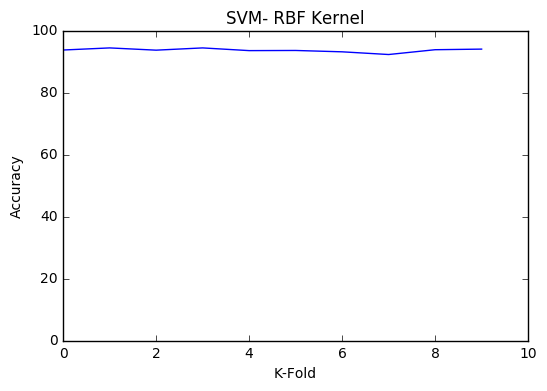

In [18]:
Y_test = []
accuracy_r = []
total = 0
for i in range(0,K_fold):
    y_test = svm_model(ker="rbf",softmargin=10,training_set=training_dataset[i], training_labels= training_labels[i],
                       testing_set = testing_dataset[i])
    result = accuracy(testing_labels[i], y_test)
    print "Accuracy :", result
    accuracy_r.append(result)
    total = total +result
    Y_test.append(y_test)
    cf = confusion_mat(testing_labels[i], Y_test[i])
    print cf
print "Average Accuracy :" , total / K_fold
accuracy_plot(accuracy_r,K_fold,"SVM- RBF Kernel")

In [373]:
'''
GridSearchCV sklearn to find the optimize parameter for SVM
Used Grid Search CV Sklearn module
Cross Validation = 3
To find which kernel will permorn best with other soft margin and other tuning parameters
'''

def svm_model_test(training_set, training_labels, testing_set):
    tuned_parameters = [{'kernel' : ['rbf'], 'gamma': [0.1, 1e-2], 'C': [10, 100], 'class_weight': [{1:1.0145294978059483},{1:1}]},
                    {'kernel' : ['poly'], 'degree' : [5, 9], 'C' : [1, 10,100], 'class_weight': [{1:1.0145294978059483}],{1:1}}] 
    classifier = GridSearchCV(svm.SVC(),tuned_parameters,verbose=2,cv=3)
    classifier.fit(training_set.T, training_labels.reshape(training_labels.shape[1],1).ravel())
    predictions_svm= classifier.predict(testing_set.T)
    print classifier.best_estimator_
    print classifier.best_score_
    print classifier.best_params_

In [374]:
svm_model_test(training_dataset[4], training_labels[4], testing_dataset[4])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] kernel=rbf, C=10, gamma=0.1, class_weight={1: 1.0145294978059483} 
[CV]  kernel=rbf, C=10, gamma=0.1, class_weight={1: 1.0145294978059483} - 2.4min
[CV] kernel=rbf, C=10, gamma=0.1, class_weight={1: 1.0145294978059483} 
[CV]  kernel=rbf, C=10, gamma=0.1, class_weight={1: 1.0145294978059483} - 2.5min
[CV] kernel=rbf, C=10, gamma=0.1, class_weight={1: 1.0145294978059483} 
[CV]  kernel=rbf, C=10, gamma=0.1, class_weight={1: 1.0145294978059483} - 2.4min
[CV] kernel=rbf, C=10, gamma=0.01, class_weight={1: 1.0145294978059483} 
[CV]  kernel=rbf, C=10, gamma=0.01, class_weight={1: 1.0145294978059483} -  31.8s
[CV] kernel=rbf, C=10, gamma=0.01, class_weight={1: 1.0145294978059483} 
[CV]  kernel=rbf, C=10, gamma=0.01, class_weight={1: 1.0145294978059483} -  31.7s
[CV] kernel=rbf, C=10, gamma=0.01, class_weight={1: 1.0145294978059483} 
[CV]  kernel=rbf, C=10, gamma=0.01, class_weight={1: 1.0145294978059483} -  31.5s
[CV] kernel=rbf

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 30.7min finished


SVC(C=10, cache_size=200, class_weight={1: 1.0145294978059483}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.929600946542
{'kernel': 'rbf', 'C': 10, 'gamma': 0.01, 'class_weight': {1: 1.0145294978059483}}


# Final Output : 

1. As per Experiment Results I choose SVM with RBF kernel
2. SVM with following Parameters {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
3. Trained the Model on The Training Dataset
4. Used the Utitlity model from the Examples
5. Stored the Results : fingersense-test-labels.csv

In [377]:
'''
final or performing classification on test data using SVM classifier
'''
# Loading the test data  
test_instances = load_instances("data/test")
X_test = generate_features(test_instances)


# fiting the svm model 

y_test = svm_model(ker="rbf",softmargin=10,training_set=X_train.T, training_labels= y_train.T,
                       testing_set = X_test.T)

#y_test = logisticRegression_model(X_train.T,y_train.T,X_test.T)

# prepare test data

timestamps = load_timestamps(test_instances)

# predict
#y_test = test_model(X_test, model)
classlabels = convert_to_classlabels(y_test)

# save results
#print(accuracy(y_test_labels,y_test))
write_results(timestamps, classlabels, "./fingersense-test-labels.csv")
